## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Generating data

In [4]:
def generate_instance(bin_size=8, a=None, b=None):
    max_int = 2 ** bin_size - 1
    int2bin = lambda n: np.array([int(i) for i in np.binary_repr(n, bin_size)], dtype=np.int32)
    
    a = np.random.randint(0, max_int // 2) if a is None else a
    x1 = int2bin(a)
    
    b = np.random.randint(0, max_int // 2) if b is None else b
    x2 = int2bin(b)
    
    c = a + b
    y = int2bin(c)
    return x1,x2,y

In [5]:
def generate_batch(batch_size=100, bin_size=8):
    X = np.zeros(shape=[batch_size, bin_size, 2], dtype=np.int32)
    Y = np.zeros(shape=(batch_size, bin_size), dtype=np.int32)
    for i in range(batch_size):
        x1,x2,y = generate_instance(bin_size)
        X[i,:,0] = x1
        X[i,:,1] = x2
        Y[i,:] = y
    return X, Y

In [6]:
def ints2bins(ints, bin_size=8, concatenate=False):
    if concatenate:
        X = np.zeros([len(ints)**2, bin_size*2])
    else:
        X = np.zeros([len(ints)**2, bin_size, 2])
    
    Y = np.zeros([len(ints)**2, bin_size])
    
    for i, a in enumerate(ints):
        for j, b in enumerate(ints):
            row_idx = i+j
            x1,x2,y = generate_instance(bin_size, a, b)
            if concatenate:
                X[row_idx,:] = np.concatenate((x1,x2))
            else:
                X[row_idx,:,0] = x1
                X[row_idx,:,1] = x2
            Y[row_idx,:] = y
    return X,Y

In [7]:
# This is if we want to make test instances that never appeared in the training set
def generate_train_test_set(bin_size=8, test_ratio=0.2, concatenate=False):
    max_int = 2 ** (bin_size-1)
    
    test_ints = np.random.choice(range(max_int), int(test_ratio*max_int), replace=False)
    train_ints = [i for i in range(max_int) if i not in test_ints]
    
    train_X, train_Y = ints2bins(train_ints, bin_size, concatenate)
    test_X, test_Y = ints2bins(test_ints, bin_size, concatenate)
    
    return train_X, train_Y, test_X, test_Y

### 100 integers are used for training
### The other 28 ones are used for testing

In [8]:
seed = 48
bin_size=8
hidden_size = 16

np.random.seed(seed)

In [9]:
train_X, train_Y, test_X, test_Y = generate_train_test_set(concatenate=True)
train_X.shape, train_Y.shape

((10609, 16), (10609, 8))

## First: Linear Regression
<img src="http://www.biostathandbook.com/pix/regressionlollipop.gif">

In [10]:
graph = tf.Graph()
with graph.as_default():
    train_x = tf.placeholder(tf.float32, [None, bin_size*2])
    train_y = tf.placeholder(tf.float32, [None, bin_size])
    
    theta = tf.Variable(
        tf.random_normal(shape=[bin_size*2, bin_size])
    )
    bias = tf.Variable(
        tf.zeros(shape=[bin_size])
    )
    
    pred = tf.add(tf.matmul(train_x,theta),bias)
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(mse)

In [11]:
def run_session(graph, loss_func="euclidean distance"):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {train_x:train_X, train_y:train_Y}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {train_x:test_X, train_y:test_Y}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Test {5}: {3}\n
                        Test MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
    return training, testing, training_mse, testing_mse

In [12]:
def plot_results(training, testing, training_mse, testing_mse, loss_func="Euclidean Distance"):
    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(training.keys())
    data1 = [training[i] for i in xticks]
    data2 = [testing[i] for i in xticks]
    data3 = [training_mse[i] for i in xticks]
    data4 = [testing_mse[i] for i in xticks]

    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(loss_func)
    ax1.plot(xticks, data1, color=color1)
    ax1.plot(xticks, data2, color=color2)
    ax1.tick_params(axis='y')

    ax1.legend(["Train %s"%loss_func, "Test %s"%loss_func])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:red'
    color2 = 'yellow'
    ax2.set_ylabel('MSE')
    ax2.plot(xticks, data3, color=color1)
    ax2.plot(xticks, data4, color=color2)
    ax2.tick_params(axis='y')
    ax2.legend(["Train MSE", "Test MSE"], loc=9)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [13]:
# training, testing, training_mse, testing_mse = run_session(graph)

Epoch 0

                        Train euclidean distance: 88.3274154663086

                        Train MSE: 0.09192351996898651

                        Test euclidean distance: 59.662574768066406

                        Test MSE: 0.7119246125221252
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train euclidean distance: 76.97274780273438

                        Train MSE: 0.06980869919061661

                        Test euclidean distance: 55.155784606933594

                        Test MSE: 0.6084321141242981
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train euclidean distance: 68.96283721923828

                        Train MSE: 0.056035831570625305

                        Test euclidean distance: 52.01891326904297

                        Test MSE: 0.5411934852600098
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train euclidean distance: 63.096717834472656

                      

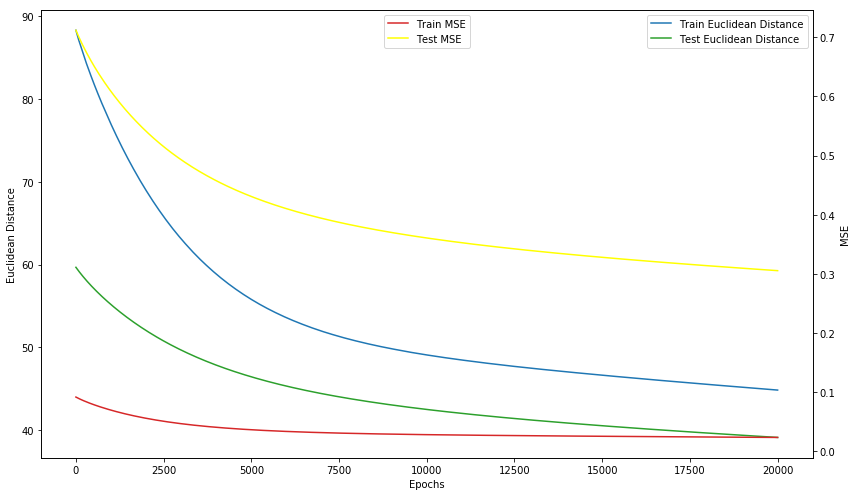

In [14]:
# plot_results(training, testing, training_mse, testing_mse)

## Second: Single-Layer Perceptron
<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

In [15]:
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(seed)
    train_x = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    train_y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    def model(data):
        return tf.add(tf.matmul(data,w),b)
    
    logits = model(train_x)
    pred = tf.nn.sigmoid(logits)
#     loss = tf.reduce_mean(tf.norm(train_y-pred))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [16]:
# training, testing, training_mse, testing_mse = run_session(graph, "cross_entropy")

Epoch 0

                        Train cross_entropy: 0.3111182749271393

                        Train MSE: 0.2522872984409332

                        Test cross_entropy: 1.0777736902236938

                        Test MSE: 0.2589549720287323
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train cross_entropy: 0.2661778926849365

                        Train MSE: 0.07942737638950348

                        Test cross_entropy: 1.069934368133545

                        Test MSE: 0.10450528562068939
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train cross_entropy: 0.2630438208580017

                        Train MSE: 0.02292986400425434

                        Test cross_entropy: 1.0986732244491577

                        Test MSE: 0.051446400582790375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train cross_entropy: 0.26211193203926086

                        Train MSE: 0.01140234805643

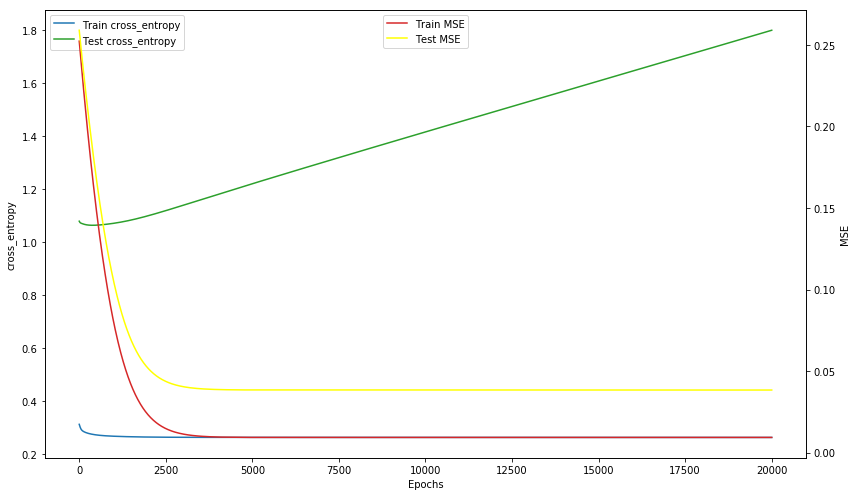

In [17]:
# plot_results(training, testing, training_mse, testing_mse, "cross_entropy")

### Third: Feedforward NN (no recurrence yet)

In [18]:
graph = tf.Graph()

with graph.as_default():
    x1 = tf.placeholder(tf.float32, [None, bin_size])
    x2 = tf.placeholder(tf.float32, [None, bin_size])
    train_y = tf.placeholder(tf.float32, [None, bin_size])
    
    W1 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    W2 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    b = tf.Variable(tf.random_normal([bin_size]))
    
    logits = tf.add(tf.add(tf.matmul(x1, W1), tf.matmul(x2, W2)), b)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))
    
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, tf.nn.sigmoid(logits)))

In [19]:
train_X, train_Y, test_X, test_Y = generate_train_test_set()
train_X.shape, train_Y.shape

((10609, 8, 2), (10609, 8))

In [20]:
train_x1 = train_X[:,:,0]
train_x2 = train_X[:,:,1]

test_x1 = test_X[:,:,0]
test_x2 = test_X[:,:,1]

In [21]:
def run_session_rnn(graph, loss_func="cross_entropy"):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {x1:train_x1, x2:train_x2, train_y: train_Y}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {x1:test_x1, x2:test_x2, train_y: test_Y}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Test {5}: {3}\n
                        Test MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
    return training, testing, training_mse, testing_mse

In [22]:
# training, testing, training_mse, testing_mse = run_session_rnn(graph)

Epoch 0

                        Train cross_entropy: 0.3157345652580261

                        Train MSE: 0.37951183319091797

                        Test cross_entropy: 1.1134111881256104

                        Test MSE: 0.3782196640968323
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train cross_entropy: 0.30151259899139404

                        Train MSE: 0.1256672739982605

                        Test cross_entropy: 1.121490240097046

                        Test MSE: 0.1391342431306839
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train cross_entropy: 0.29193365573883057

                        Train MSE: 0.025392422452569008

                        Test cross_entropy: 1.1040763854980469

                        Test MSE: 0.044497910887002945
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train cross_entropy: 0.2830319404602051

                        Train MSE: 0.0088413301855

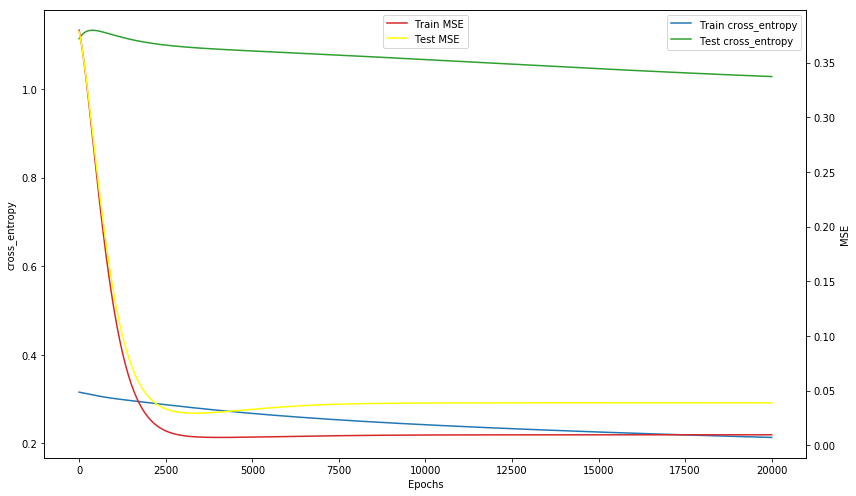

In [23]:
# plot_results(training, testing, training_mse, testing_mse, "cross_entropy")

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>

In [24]:
h_size = 16

In [30]:
graph = tf.Graph()
with graph.as_default():
    x1 = tf.placeholder(tf.float32, [None, bin_size])
    x2 = tf.placeholder(tf.float32, [None, bin_size])
    train_y = tf.placeholder(tf.float32, [None, bin_size])
    
    basic_cell = tf.contrib.rnn.BasicRNNCell(bin_size)
    output_seq, pred = tf.contrib.rnn.static_rnn(basic_cell, [x1, x2], dtype=tf.float32)
    
    
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [31]:
training, testing, training_mse, testing_mse = run_session_rnn(graph, 'Eculidean Distance')

Epoch 0

                        Train Eculidean Distance: 31.23476219177246

                        Train MSE: 0.011495079845190048

                        Test Eculidean Distance: 14.814906120300293

                        Test MSE: 0.04389628767967224
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train Eculidean Distance: 17.783348083496094

                        Train MSE: 0.0037261699326336384

                        Test Eculidean Distance: 14.137089729309082

                        Test MSE: 0.03997145965695381
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train Eculidean Distance: 17.357328414916992

                        Train MSE: 0.0035497788339853287

                        Test Eculidean Distance: 14.16035270690918

                        Test MSE: 0.04010311886668205
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train Eculidean Distance: 17.61282730102539

             

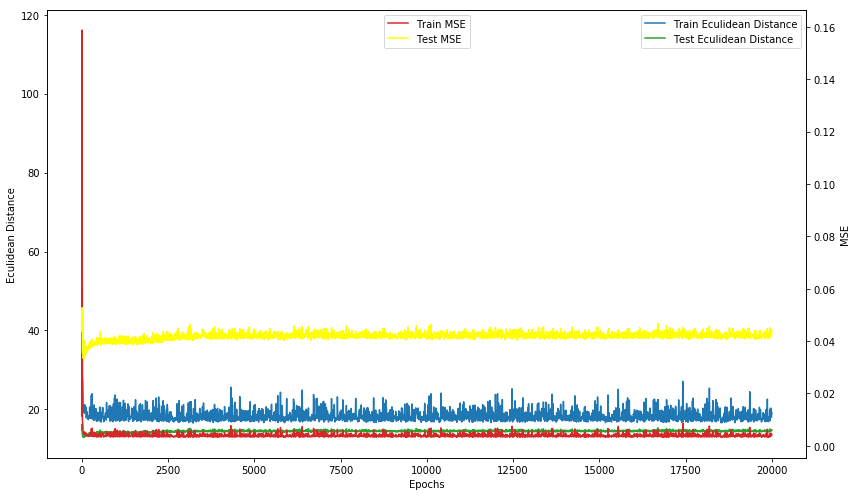

In [32]:
plot_results(training, testing, training_mse, testing_mse, "Eculidean Distance")